### Load packages

In [1]:
import scanpy as sc
import episcanpy.api as epi
import numpy as np
import anndata as ad
import random
import copy
import pandas as pd

/home/icb/anna.danese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/icb/anna.danese/.local/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

# Pre-processing 10x
We need to filter the barcodes. 

### Load the 10x windows count matrix

In [3]:
input_dir_10x = './data_integration_datasets/10x/merged_peaks_small/'

adata = ad.read(input_dir_10x+'atac_v1_adult_brain_fresh_5k_fragments_AllCells.h5ad')
adata

AnnData object with n_obs × n_vars = 335609 × 390259 

In [4]:
with open('filtered_peak_bc_matrix/barcodes.tsv') as f:
    barcodes = f.readlines()
    barcodes = [x.rstrip('\n') for x in barcodes]

annot = []
for name in adata.obs_names.tolist():
    if name in barcodes:
        annot.append('keep')
    else:
        annot.append('discard')
adata.obs['filter_barcode_cellranger'] = annot

adata = adata[adata.obs['filter_barcode_cellranger']=='keep',:].copy()
adata

AnnData object with n_obs × n_vars = 3880 × 390259 
    obs: 'filter_barcode_cellranger'

In [5]:
print(np.max(adata.X))
epi.pp.binarize(adata)
print(np.max(adata.X))

33.0
1.0


In [6]:
epi.pp.filter_cells(adata, min_features=100)
adata

AnnData object with n_obs × n_vars = 3872 × 390259 
    obs: 'filter_barcode_cellranger', 'nb_features'

In [7]:
epi.pp.filter_features(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 3872 × 379199 
    obs: 'filter_barcode_cellranger', 'nb_features'
    var: 'n_cells'

In [8]:
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
adata

AnnData object with n_obs × n_vars = 3872 × 379199 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells'

... storing 'filter_barcode_cellranger' as categorical


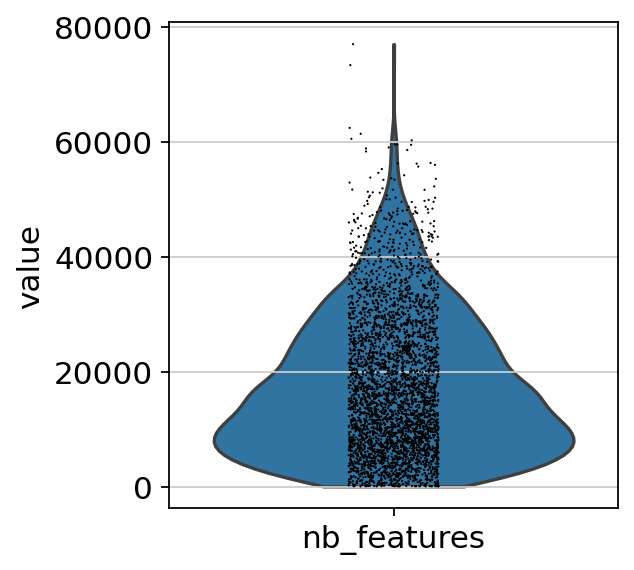

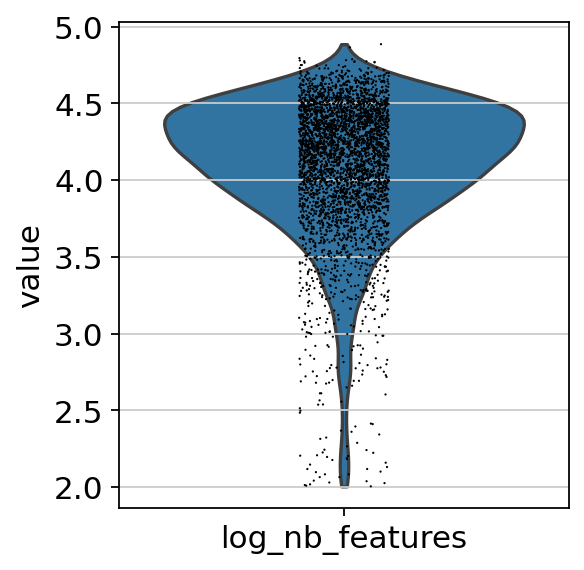

In [9]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

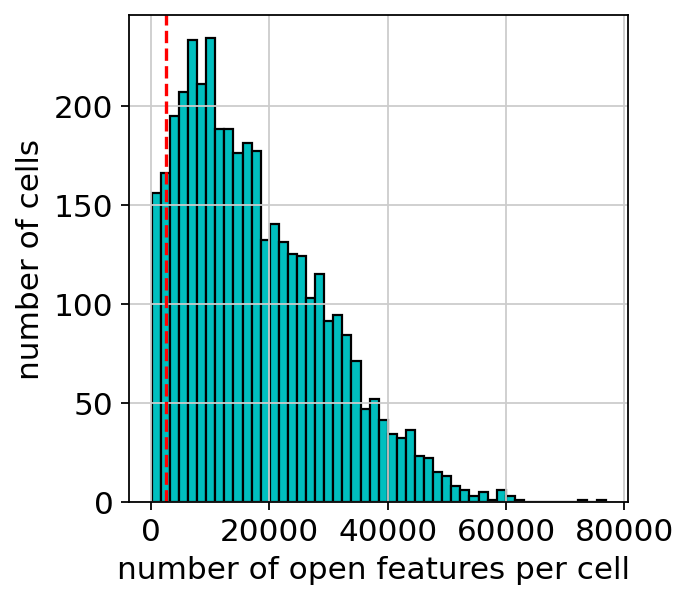

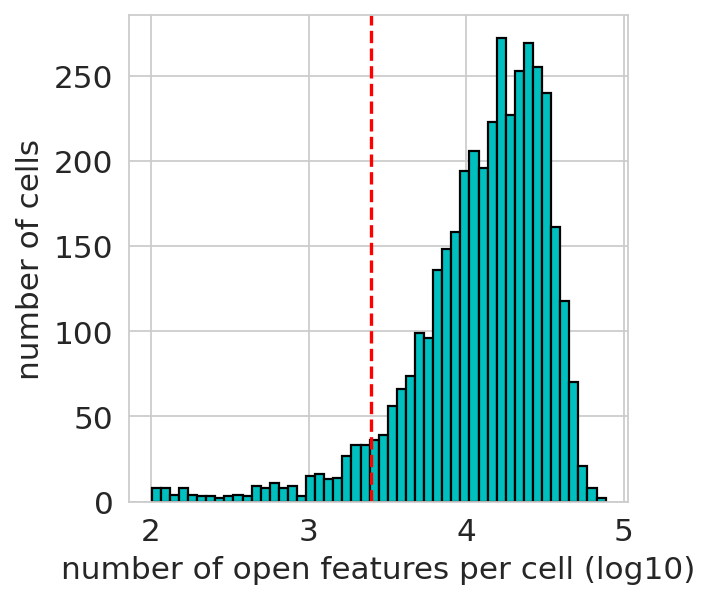

In [10]:
# set a minimum number of cells to keep 
min_features = 2500

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features, save='10x_small_peaks_coverage_cells.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features, save='10x_small_peaks_coverage_cells_log10.png')

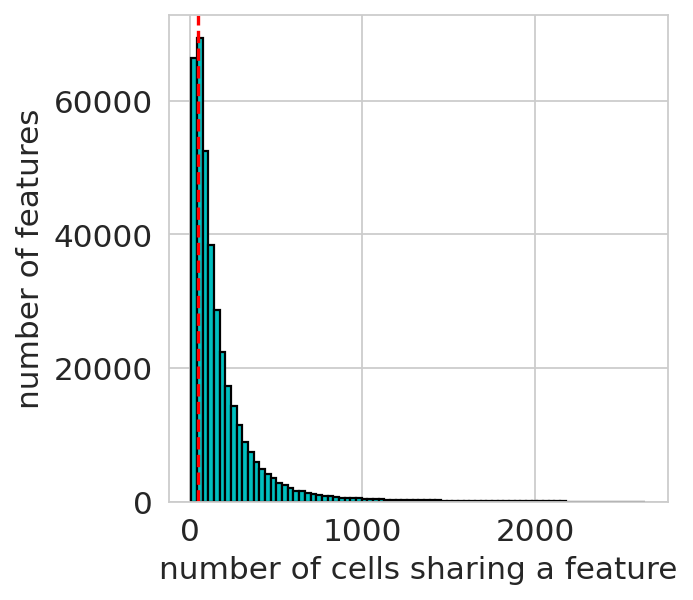

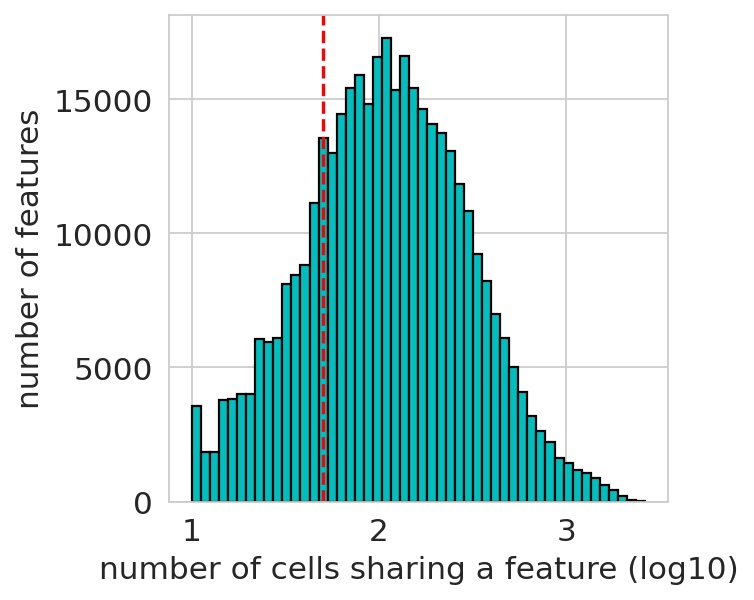

In [11]:
# minimum number of cells sharing a feature
min_cells = 50
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='10x_small_peaks_coverage.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='10x_small_peaks_coverage_log10.png')

In [12]:
min_features = 2500
epi.pp.filter_cells(adata, min_features=min_features)
adata

AnnData object with n_obs × n_vars = 3619 × 379199 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

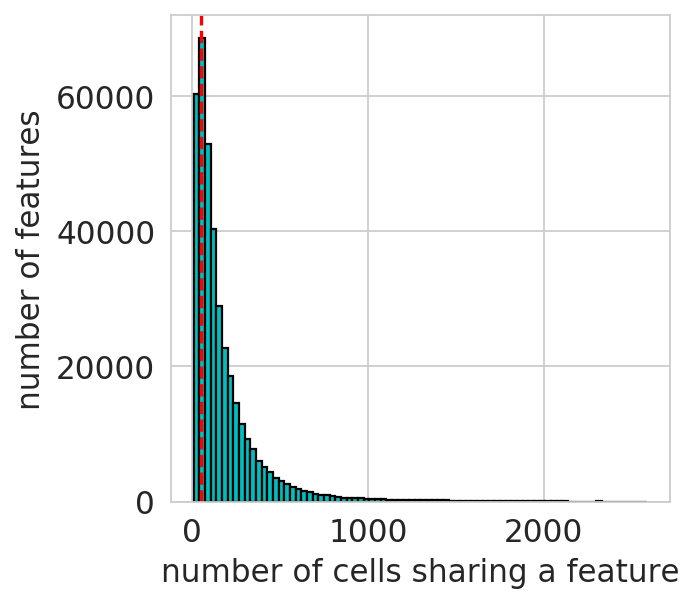

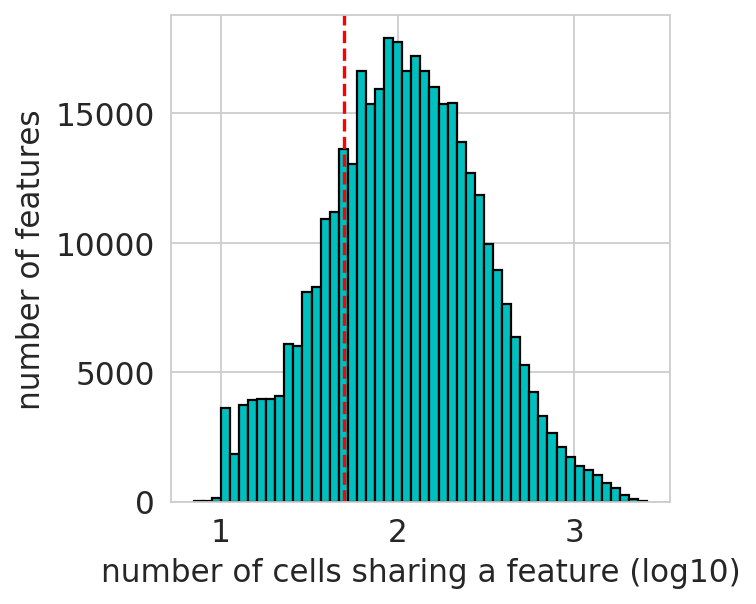

In [15]:
# minimum number of cells sharing a feature
min_cells = 50
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='10x_small_peaks_coverage.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='10x_small_peaks_coverage_log10.png')

In [13]:
min_cells = 50
epi.pp.filter_features(adata, min_cells=min_cells)
adata

AnnData object with n_obs × n_vars = 3619 × 296360 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

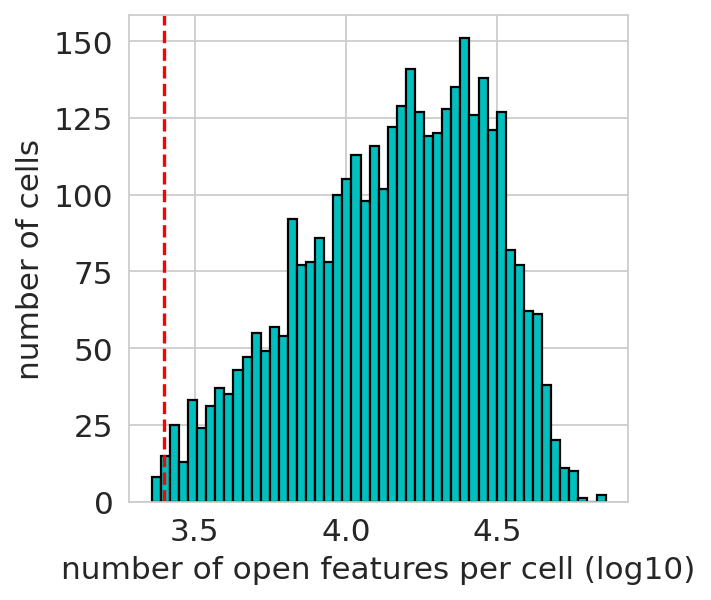

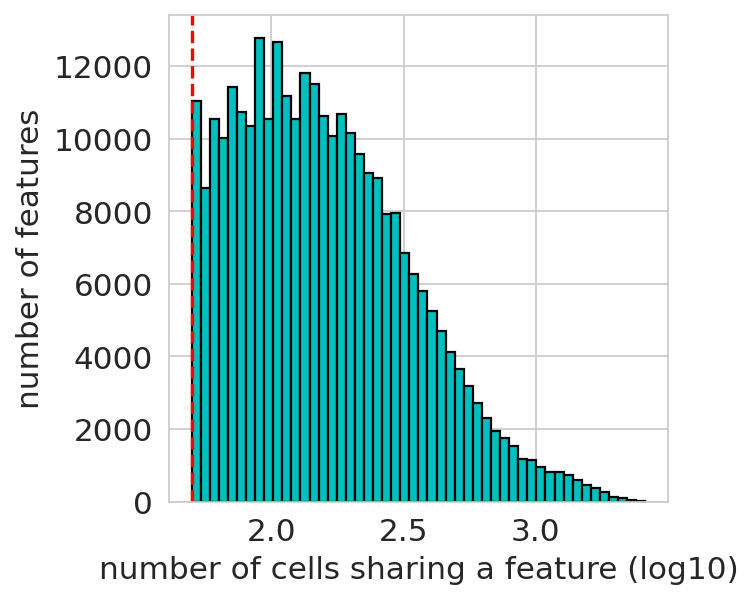

In [14]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=min_cells)

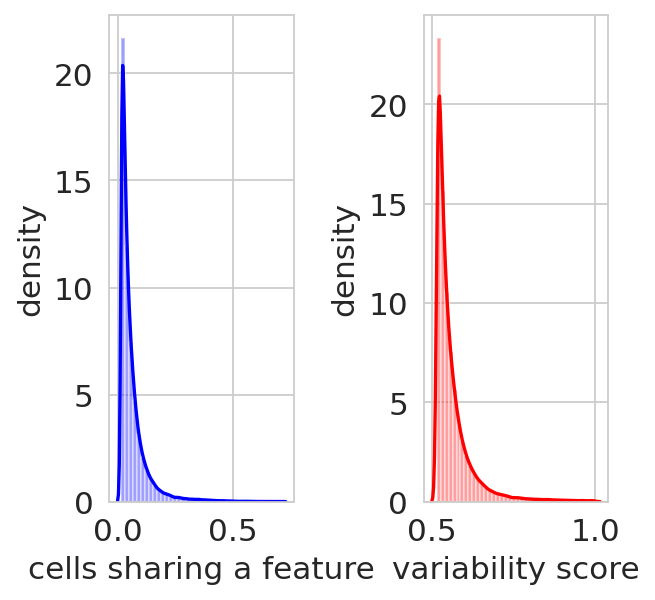

In [15]:
epi.pp.cal_var(adata)

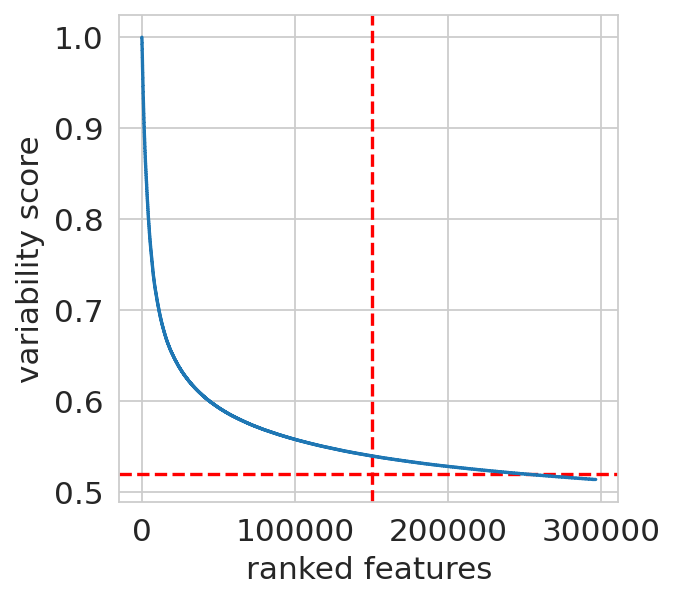

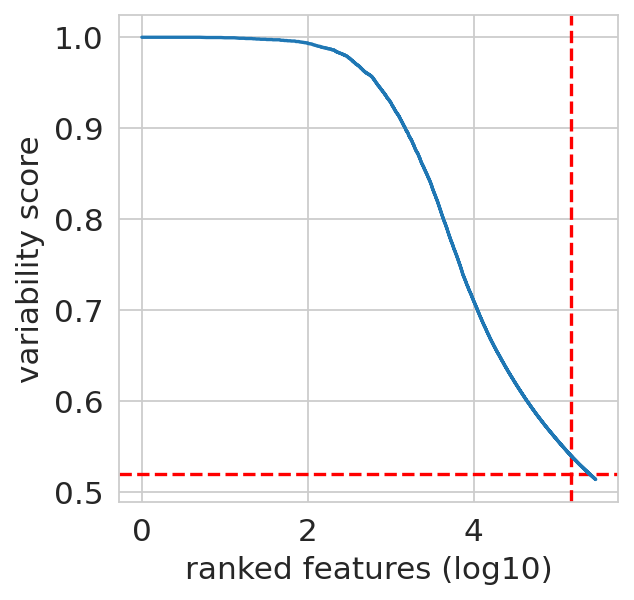

In [16]:
min_score_value = 0.52
nb_feature_selected = 150000
epi.pl.variability_features(adata,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_10x_small_peaks.png')

epi.pl.variability_features(adata,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_10x_small_peaks_log10.png')

In [17]:
# save the current matrix in the raw layer
adata.raw = adata

In [18]:
# create a new AnnData containing only the most variable features
adata = epi.pp.select_var_feature(adata,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

In [19]:
adata

View of AnnData object with n_obs × n_vars = 3619 × 150146 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

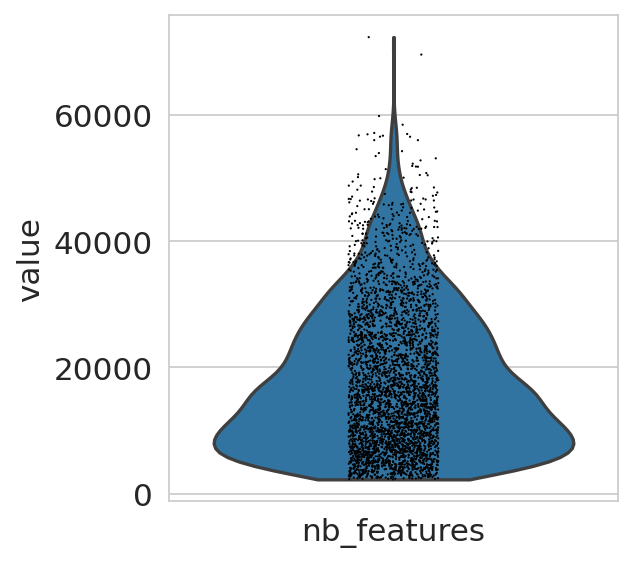

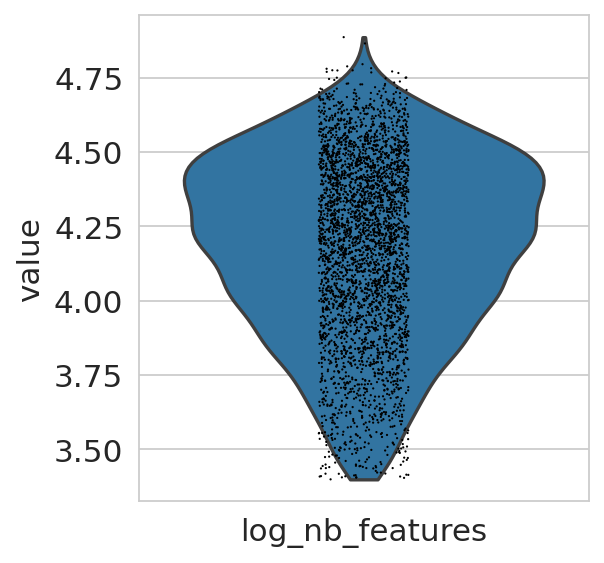

In [20]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

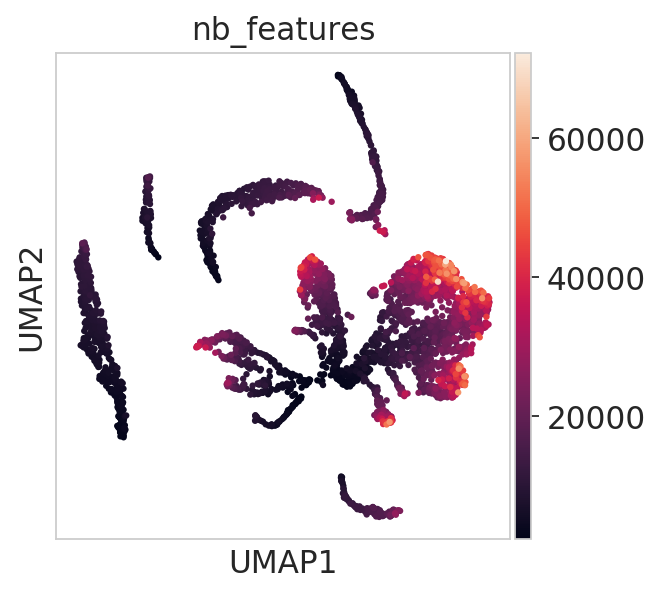

In [24]:
epi.pp.lazy(adata)
sc.pl.umap(adata, color=['nb_features'], wspace=0.3)

In [21]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata.layers['counts'] = adata.X.copy()

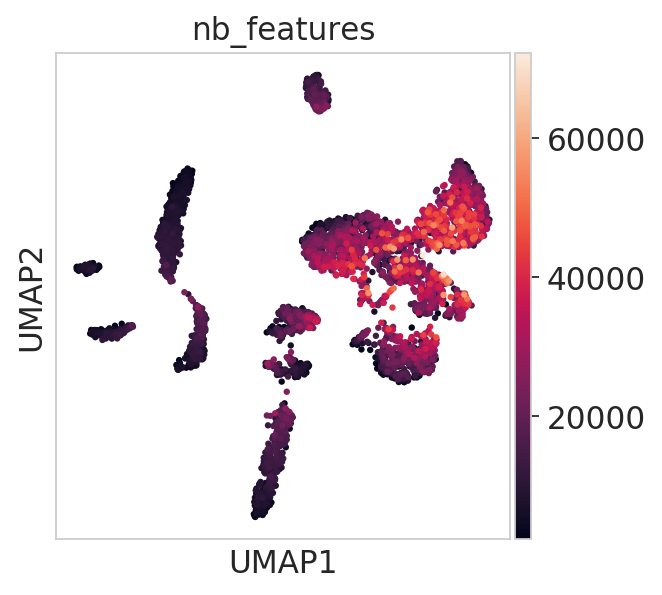

In [27]:
adata2 = adata.copy()
epi.pp.normalize_per_cell(adata2)
epi.pp.lazy(adata2)
sc.pl.umap(adata2, color=['nb_features'], wspace=0.3)

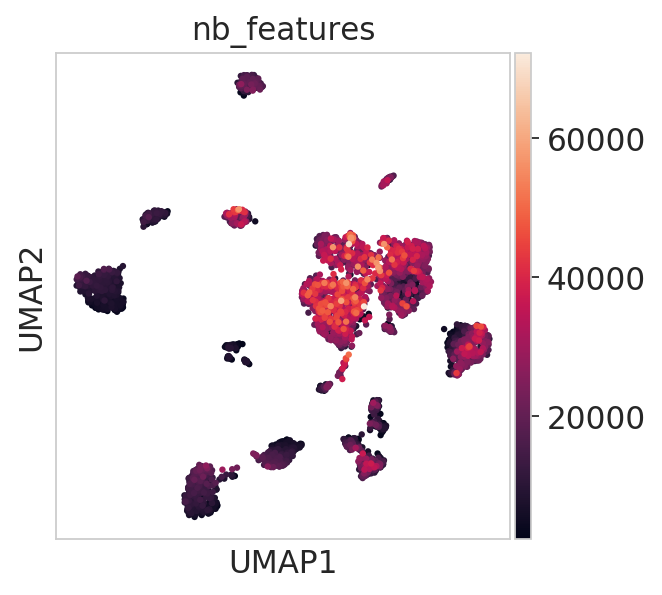

In [28]:
epi.pp.log1p(adata2)
epi.pp.lazy(adata2)
sc.pl.umap(adata2, color=['nb_features'], wspace=0.3)

## Pre-processing small Fang

In [22]:
input_dir_fang = './data_integration_datasets/fang/merged_peaks_small/'

adata2 = ad.read(input_dir_fang+'CEMBA180305_2B_AllCells.h5ad')
adata2

AnnData object with n_obs × n_vars = 88080 × 390259 

In [23]:
print(np.max(adata2.X))
epi.pp.binarize(adata2)
print(np.max(adata2.X))

88.0
1.0


In [24]:
epi.pp.filter_cells(adata2, min_features=100)
adata2

AnnData object with n_obs × n_vars = 13835 × 390259 
    obs: 'nb_features'

In [25]:
epi.pp.filter_features(adata2, min_cells=10)
adata2

AnnData object with n_obs × n_vars = 13835 × 365570 
    obs: 'nb_features'
    var: 'n_cells'

In [26]:
adata2.obs['log_nb_features'] = [np.log10(x) for x in adata2.obs['nb_features']]
adata2

AnnData object with n_obs × n_vars = 13835 × 365570 
    obs: 'nb_features', 'log_nb_features'
    var: 'n_cells'

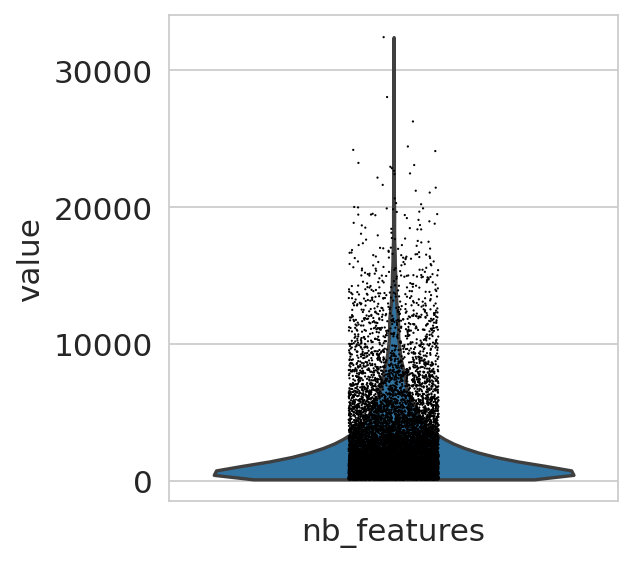

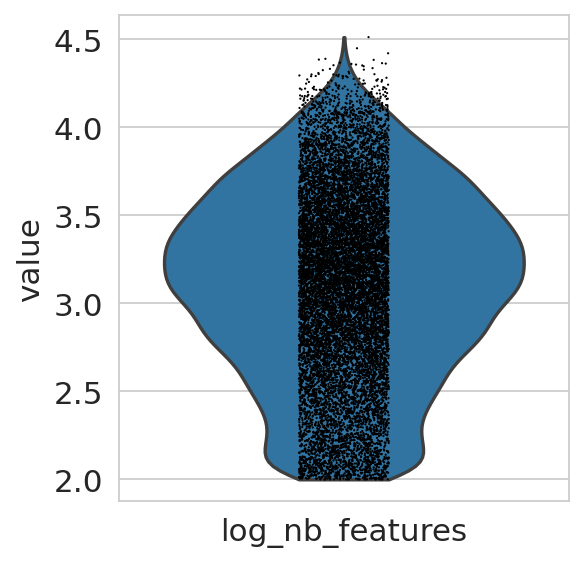

In [27]:
epi.pl.violin(adata2, ['nb_features'])
epi.pl.violin(adata2, ['log_nb_features'])

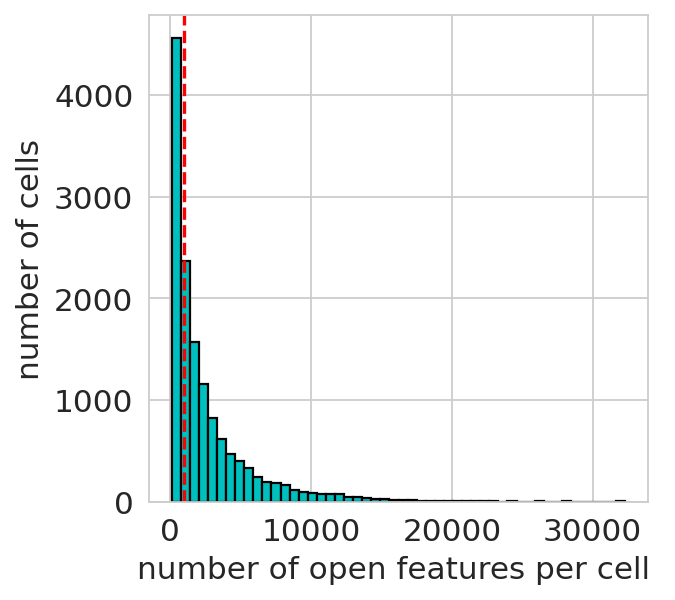

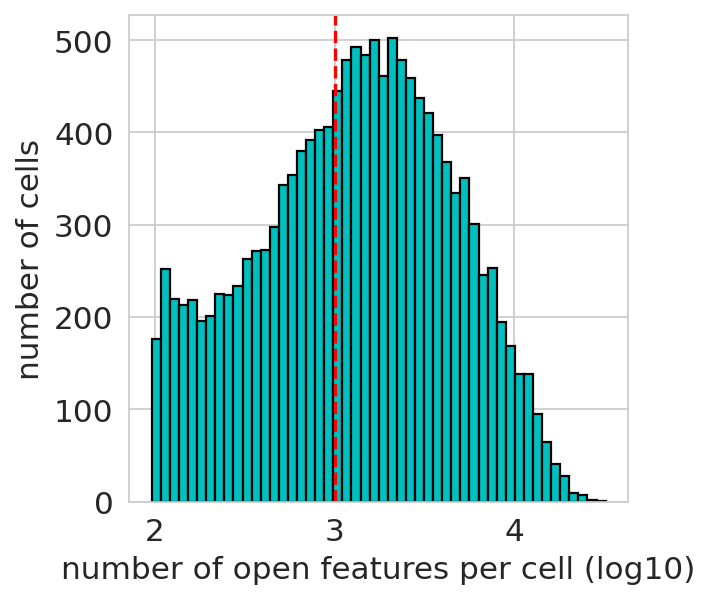

In [28]:
# set a minimum number of cells to keep 
min_features = 1000

epi.pp.coverage_cells(adata2, binary=True, log=False, bins=50,
               threshold=min_features, save='CEMBA180305_2B_peaks_small_coverage_cells.png')
epi.pp.coverage_cells(adata2, binary=True, log=10, bins=50,
               threshold=min_features, save='CEMBA180305_2B_peaks_small_coverage_cells_log10.png')

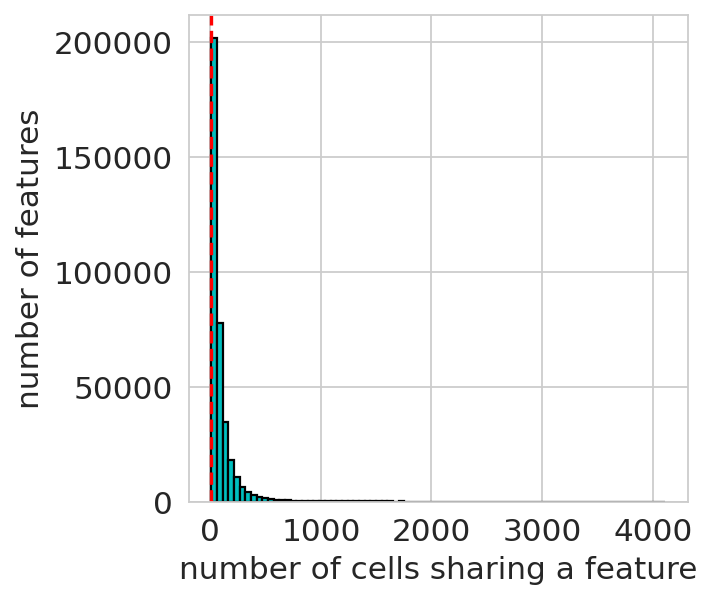

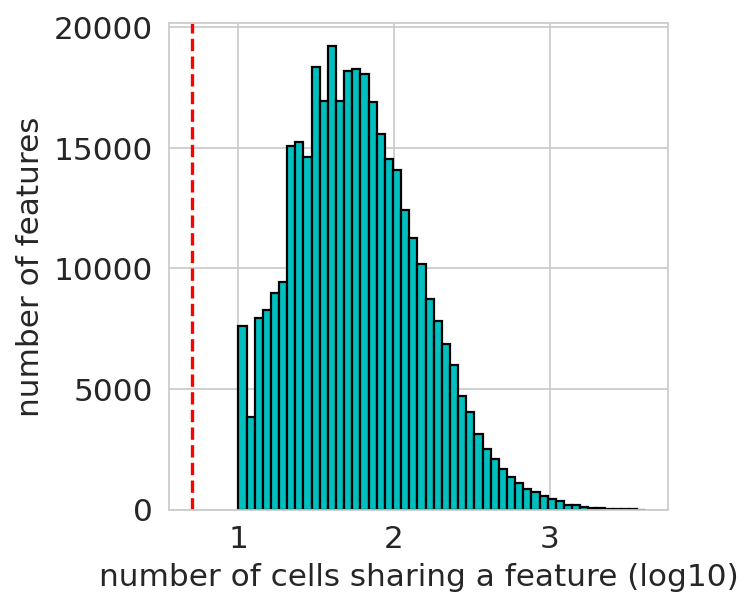

In [29]:
# minimum number of cells sharing a feature
min_cells = 5
epi.pp.coverage_features(adata2, binary=True, log=False, 
                        threshold=min_cells, save='CEMBA180305_2B_peaks_small_coverage.png')
epi.pp.coverage_features(adata2, binary=True, log=True, 
                        threshold=min_cells, save='CEMBA180305_2B_peaks_small_coverage_log10.png')

In [30]:
min_features = 1000
epi.pp.filter_cells(adata2, min_features=min_features)

### subsample

In [31]:
k = 4000
filtered_barcodes = random.sample(adata2.obs_names.tolist(), k)
annot = []
for n in adata2.obs_names.tolist():
    if n in filtered_barcodes:
        annot.append('keep')
    else:
        annot.append('discard')
adata2.obs['filter'] = annot
adata2 = adata2[adata2.obs['filter']=='keep',:].copy()
adata2

AnnData object with n_obs × n_vars = 4000 × 365570 
    obs: 'nb_features', 'log_nb_features', 'filter'
    var: 'n_cells', 'commonness'

### filter features

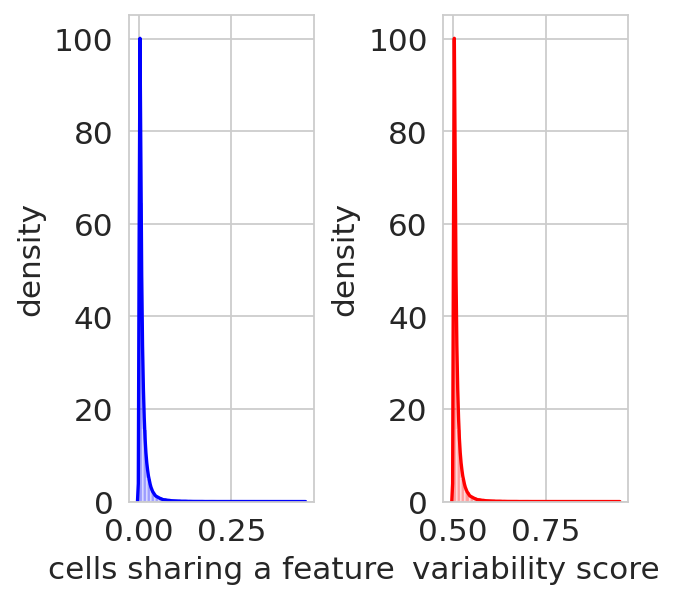

In [32]:
epi.pp.cal_var(adata2)

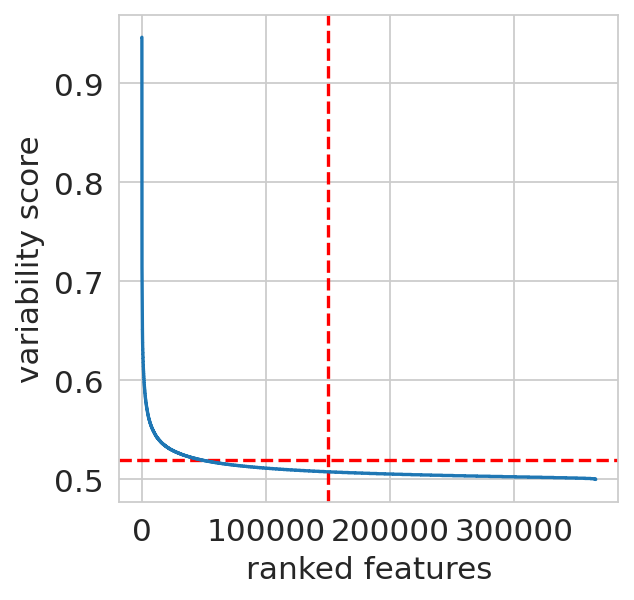

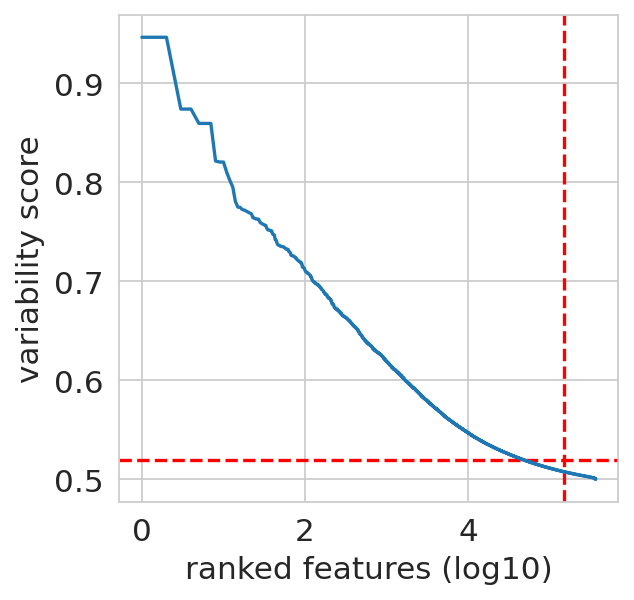

In [33]:
min_score_value = 0.52
nb_feature_selected = 150000
epi.pl.variability_features(adata2,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_CEMBA180305_2B_peaks_small.png')

epi.pl.variability_features(adata2,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_CEMBA180305_2B_peaks_small_log10.png')

In [34]:
# save the current matrix in the raw layer
adata2.raw = adata2

In [35]:
# create a new AnnData containing only the most variable features
adata2 = epi.pp.select_var_feature(adata2,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

Trying to set attribute `.obs` of view, copying.
... storing 'filter' as categorical


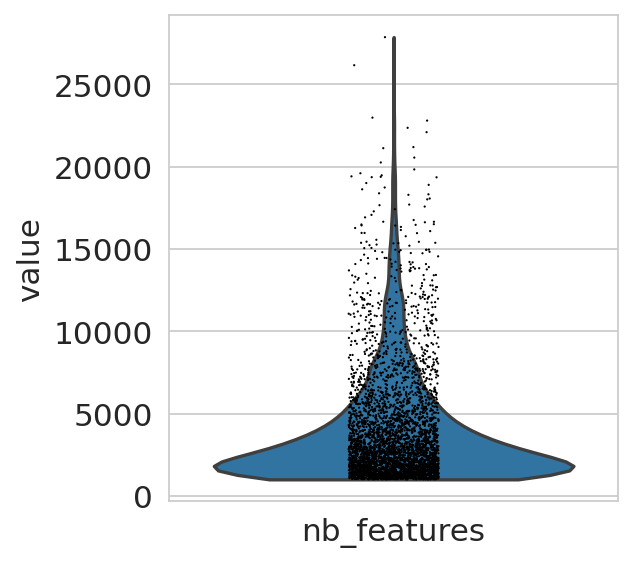

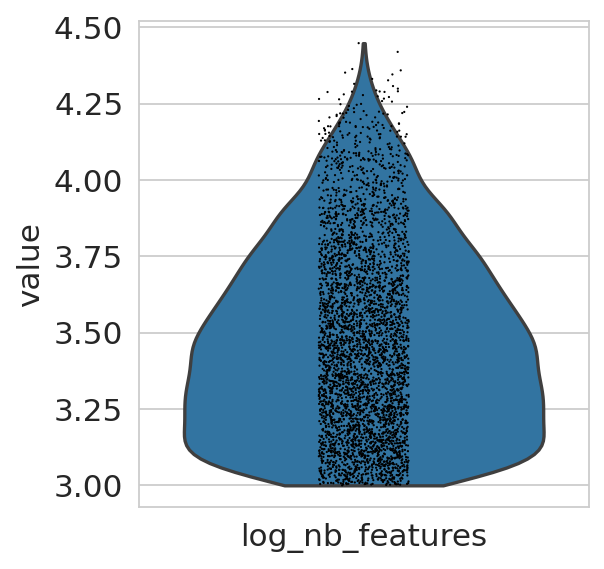

In [36]:
epi.pl.violin(adata2, ['nb_features'])
epi.pl.violin(adata2, ['log_nb_features'])

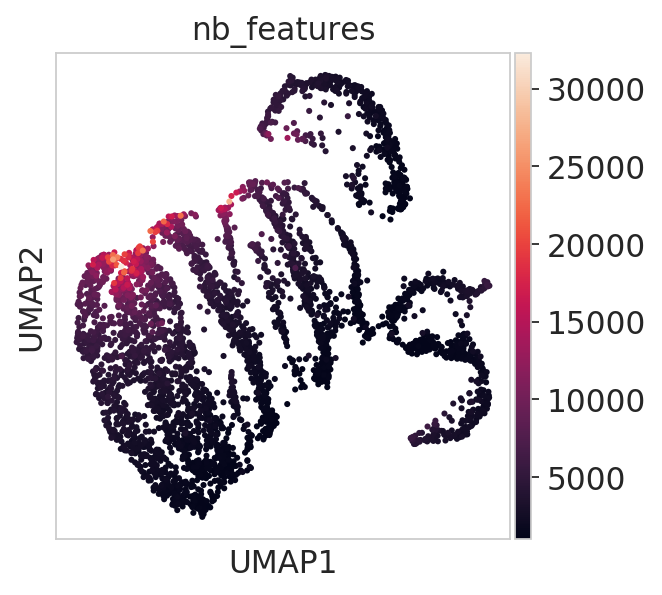

In [46]:
epi.pp.lazy(adata2)
sc.pl.umap(adata2, color=['nb_features'], wspace=0.3)

In [37]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata2.layers['counts'] = adata2.X.copy()
adata2

AnnData object with n_obs × n_vars = 4000 × 151399 
    obs: 'nb_features', 'log_nb_features', 'filter'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    layers: 'counts'

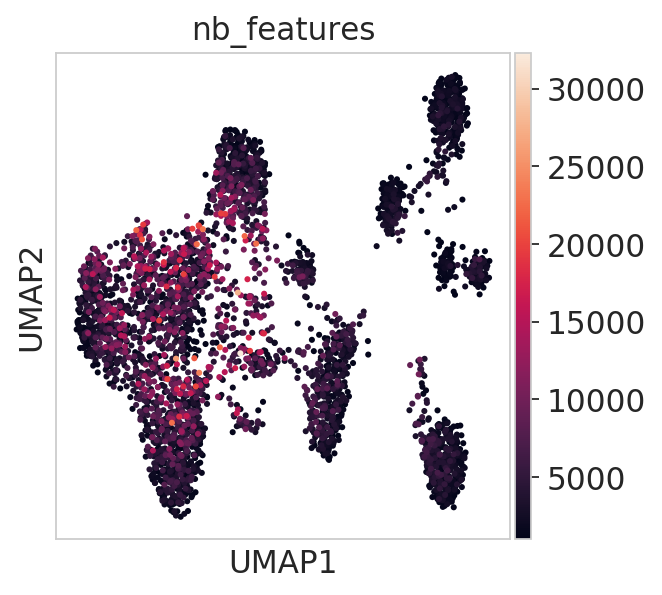

In [47]:
adata3 = adata2.copy()
epi.pp.normalize_per_cell(adata3)
epi.pp.lazy(adata3)
sc.pl.umap(adata3, color=['nb_features'], wspace=0.3)

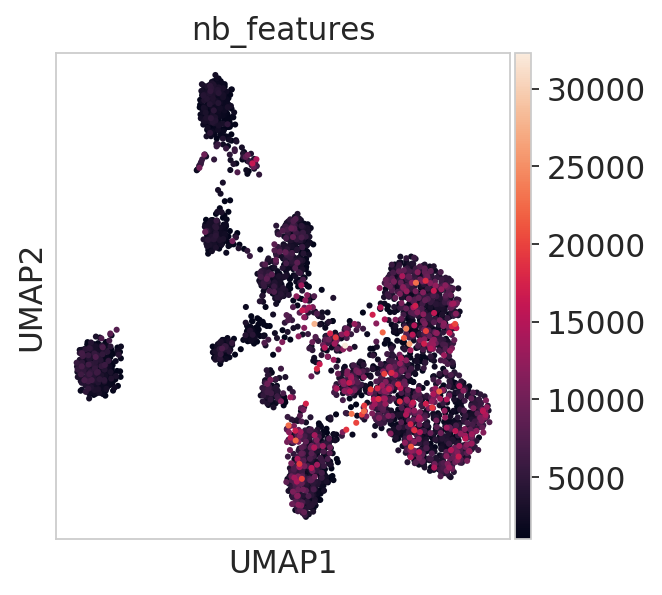

In [48]:
epi.pp.log1p(adata3)
epi.pp.lazy(adata3)
sc.pl.umap(adata3, color=['nb_features'], wspace=0.3)

## Pre processing Cusanovich small

In [45]:
input_dir_Cusanovich = './data_integration_datasets/cusanovich/merged_peaks_small/'

adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819246_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819247_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot

adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2

adata3 = adatacus1.copy()
adata3.X = adata3.X+adatacus2.X

del adata3.obs['filter'], adatacus1, adatacus2

adata3

AnnData object with n_obs × n_vars = 35018 × 390259 

In [46]:
print(np.max(adata3.X))
epi.pp.binarize(adata3)
print(np.max(adata3.X))

362.0
1.0


In [47]:
# remove any potential empty features or barcodes
epi.pp.filter_cells(adata3, min_features=1)
epi.pp.filter_features(adata3, min_cells=1)
adata3

AnnData object with n_obs × n_vars = 33808 × 390259 
    obs: 'nb_features'
    var: 'n_cells'

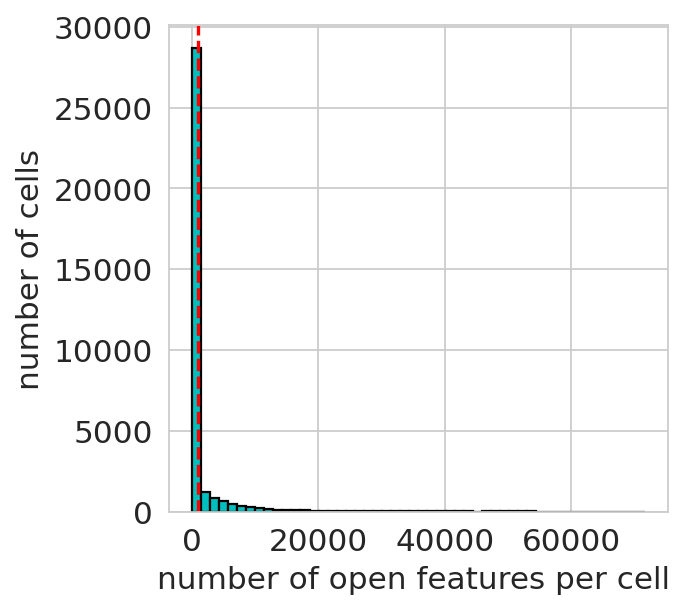

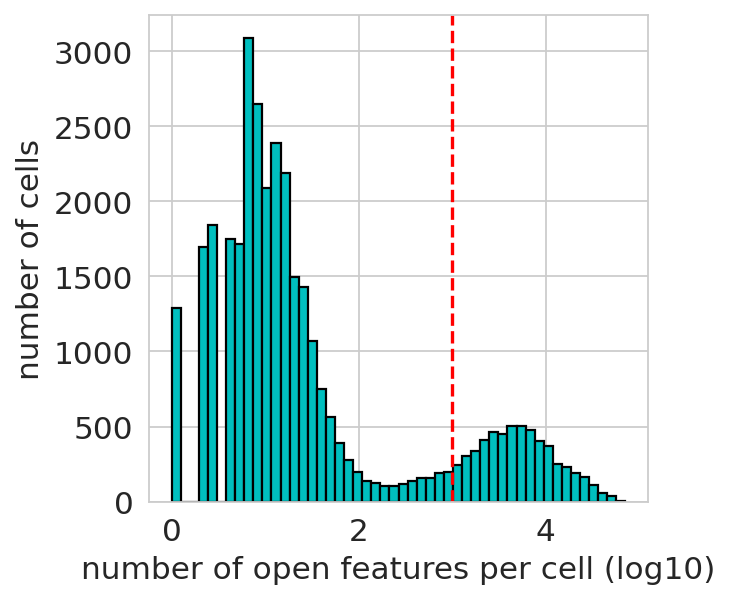

In [48]:
# set a minimum number of cells to keep 
min_features = 1000

epi.pp.coverage_cells(adata3, binary=True, log=False, bins=50,
               threshold=min_features, save='Cusanovich_coverage_cells_peaks_small.png')
epi.pp.coverage_cells(adata3, binary=True, log=10, bins=50,
               threshold=min_features, save='Cusanovich_coverage_cells_peaks_small_log10.png')

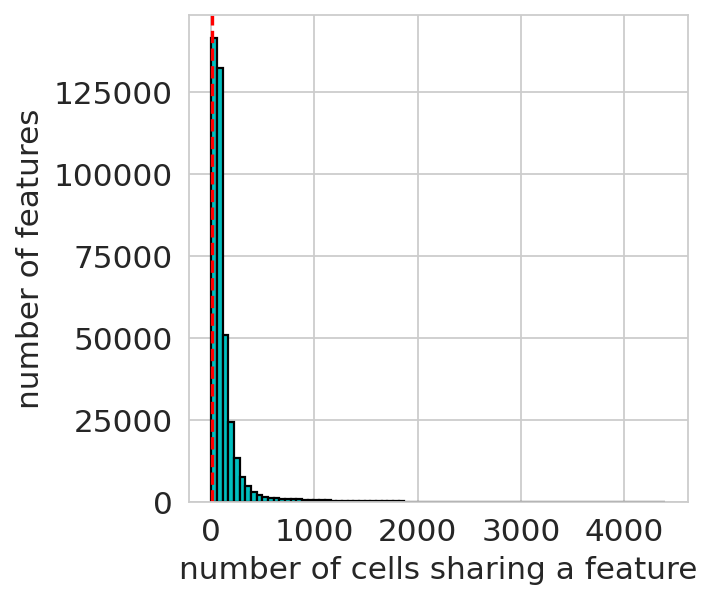

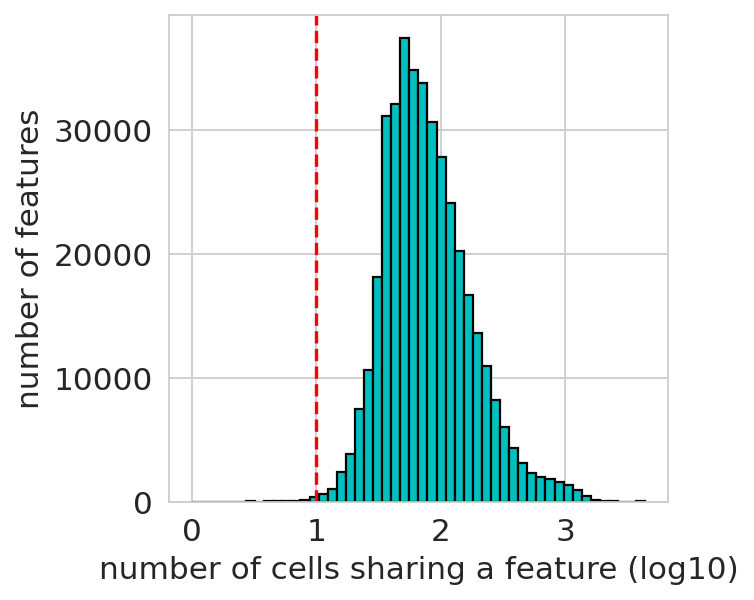

In [49]:
# minimum number of cells sharing a feature
min_cells = 10
epi.pp.coverage_features(adata3, binary=True, log=False, 
                        threshold=min_cells)
epi.pp.coverage_features(adata3, binary=True, log=True, 
                        threshold=min_cells)

In [50]:
min_features = 1000
epi.pp.filter_cells(adata3, min_features=min_features)

In [51]:
min_cells = 10
epi.pp.filter_features(adata3, min_cells=min_cells)

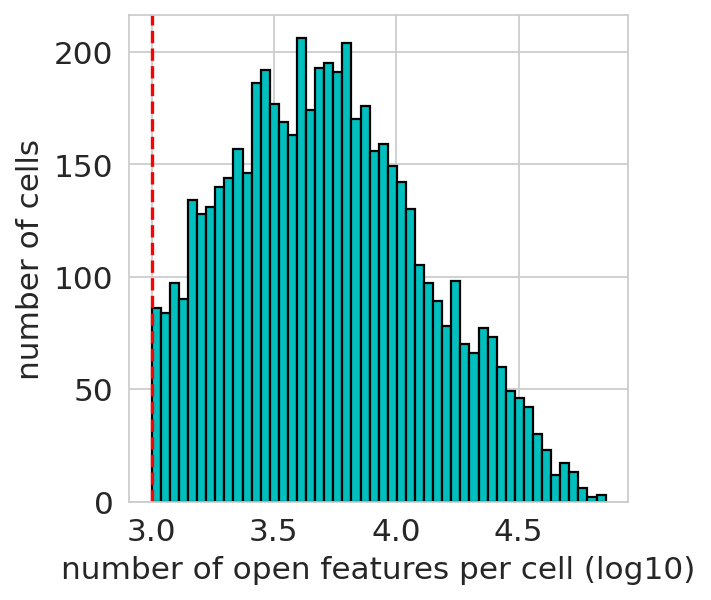

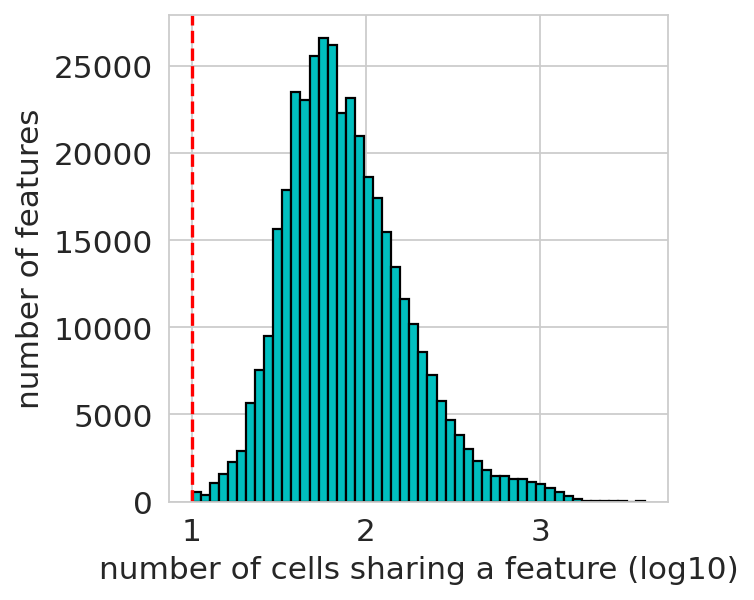

In [52]:
epi.pp.coverage_cells(adata3, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata3, binary=True, log='log10', bins=50, threshold=min_cells)



### subsample

In [53]:
k = 4000
filtered_barcodes = random.sample(adata3.obs_names.tolist(), k)
annot = []
for n in adata3.obs_names.tolist():
    if n in filtered_barcodes:
        annot.append('keep')
    else:
        annot.append('discard')
adata3.obs['filter'] = annot
adata3 = adata3[adata3.obs['filter']=='keep',:].copy()
adata3

AnnData object with n_obs × n_vars = 4000 × 389795 
    obs: 'nb_features', 'filter'
    var: 'n_cells', 'commonness'

### filter features

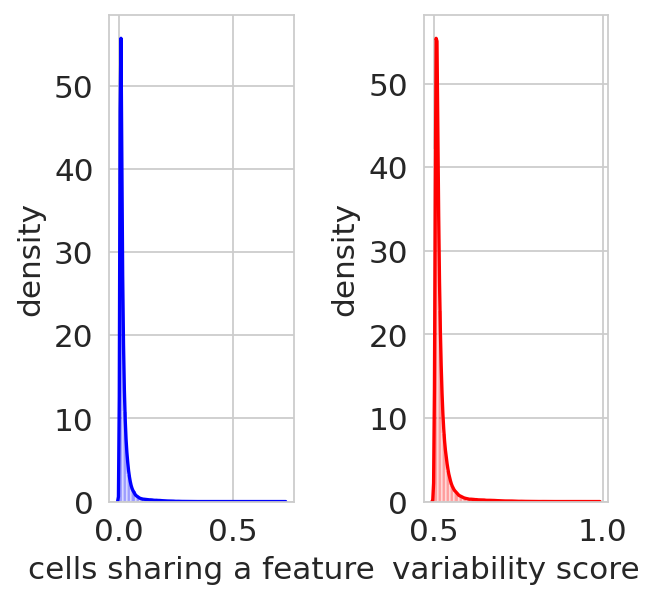

In [54]:
epi.pp.cal_var(adata3)

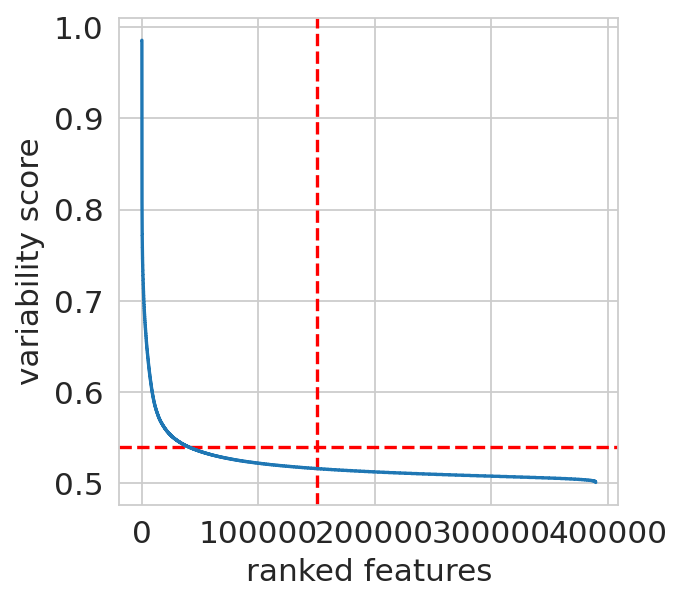

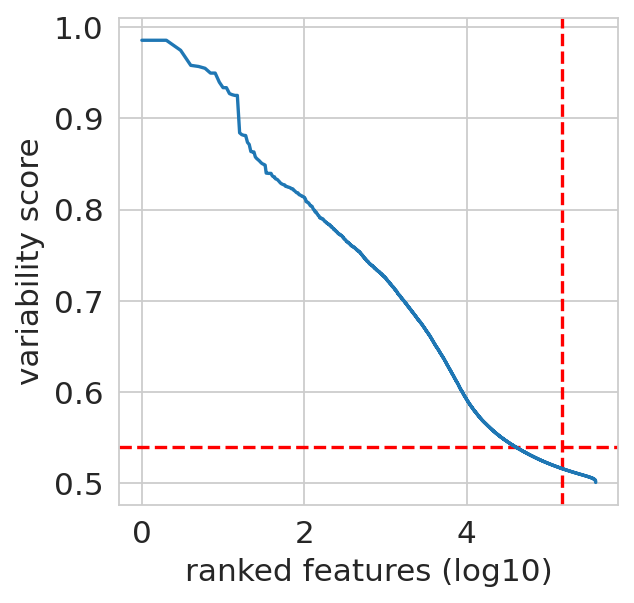

In [55]:
min_score_value = 0.54
nb_feature_selected = 150000
epi.pl.variability_features(adata3,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected)

epi.pl.variability_features(adata3,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected)

In [56]:
# save the current matrix in the raw layer
adata3.raw = adata3

In [57]:
# create a new AnnData containing only the most variable features
adata3 = epi.pp.select_var_feature(adata3,
                            nb_features=nb_feature_selected,
                            show=False,
                            copy=True)

In [58]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata3.layers['counts'] = adata3.X.copy()

... storing 'filter' as categorical


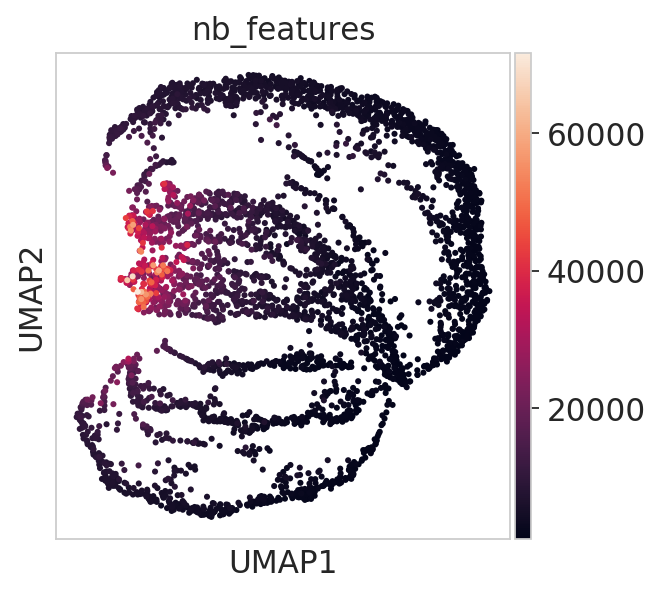

In [75]:
epi.pp.lazy(adata3)
sc.pl.umap(adata3, color=['nb_features'], wspace=0.3)

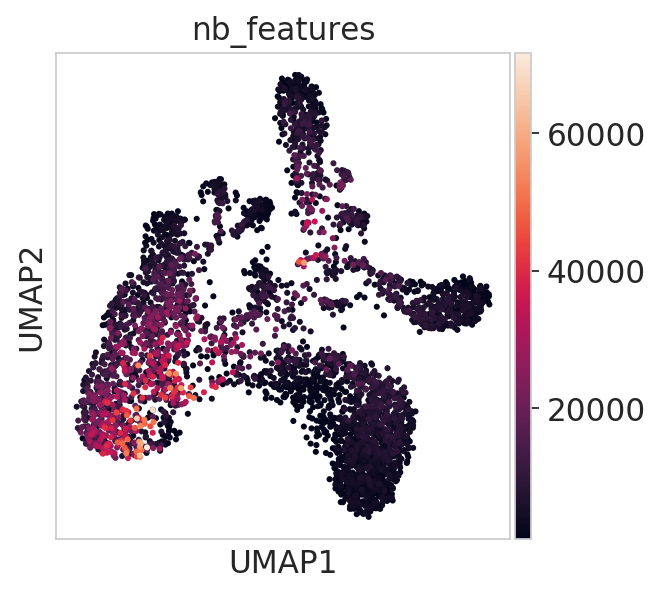

In [76]:
adata4 = adata3.copy()
epi.pp.normalize_per_cell(adata4)
epi.pp.lazy(adata4)
sc.pl.umap(adata4, color=['nb_features'], wspace=0.3)

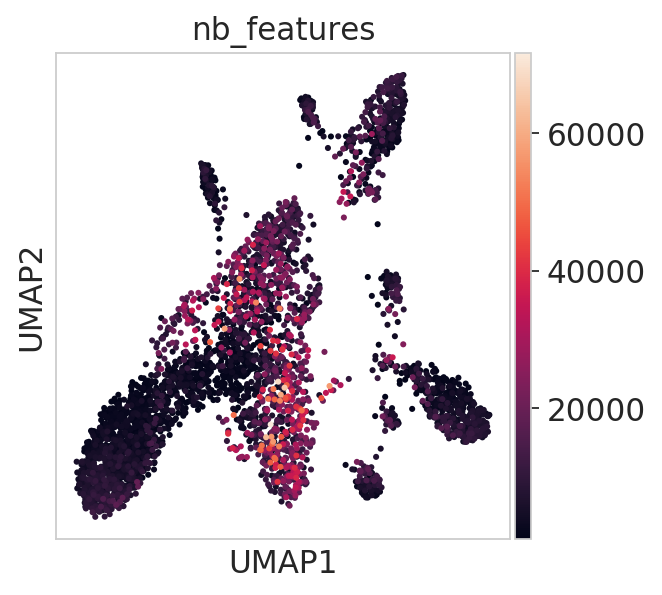

In [77]:
epi.pp.log1p(adata4)
epi.pp.lazy(adata4)
sc.pl.umap(adata4, color=['nb_features'], wspace=0.3)

In [78]:
del adata4

# merged datasets

In [59]:
adatamerged = adata.concatenate(adata2)
batchname=copy.copy(adatamerged.obs['batch'])
batchname

batchname = batchname.map({ '1' : 'Fang et al.', '0' : '10x Genomics' })
batchname

adatamerged.obs['batchname'] = batchname
adatamerged

AnnData object with n_obs × n_vars = 7619 × 119133 
    obs: 'batch', 'filter', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features', 'batchname'
    var: 'n_cells-0', 'commonness-0', 'prop_shared_cells-0', 'variability_score-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    layers: 'counts'

... storing 'filter_barcode_cellranger' as categorical
... storing 'filter' as categorical


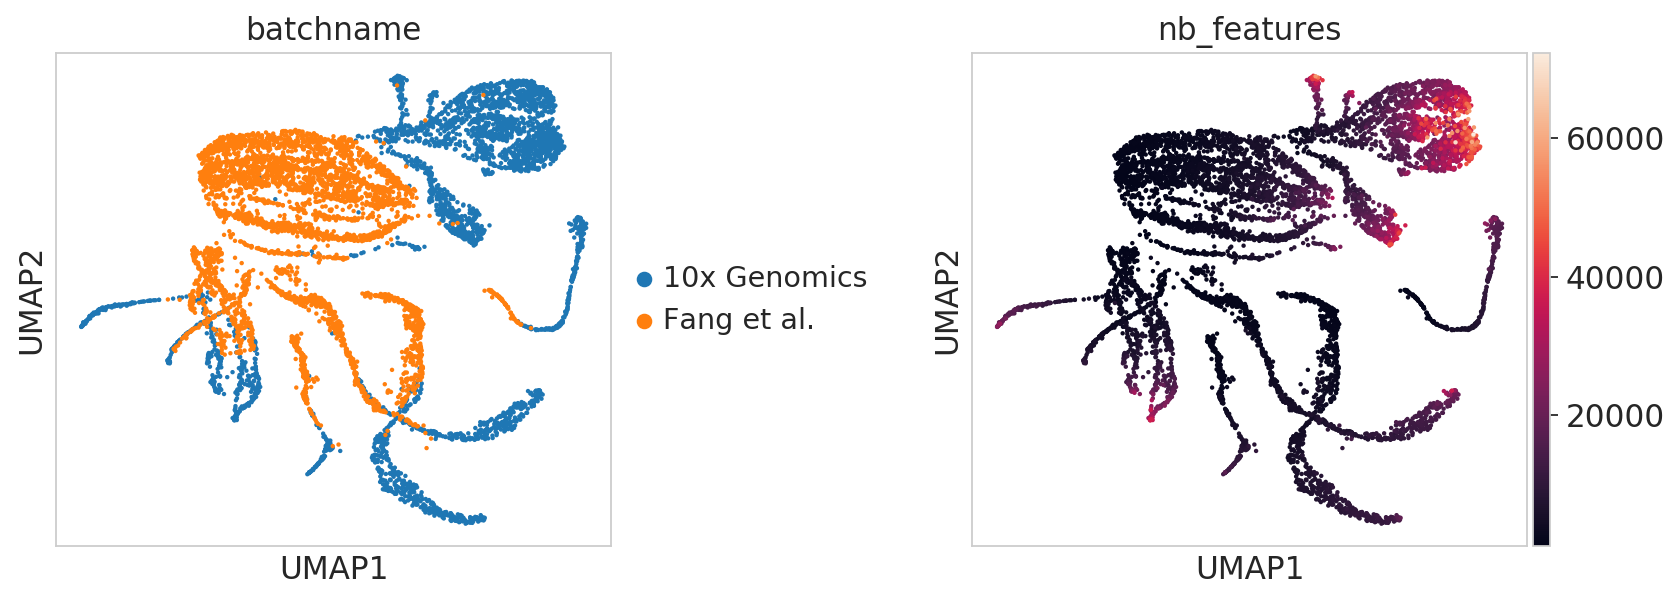

In [80]:
epi.pp.lazy(adatamerged)
sc.pl.umap(adatamerged, color=['batchname', 'nb_features'], wspace=0.5)

In [60]:
adatamerged = adatamerged.concatenate(adata3)
adatamerged.obs['batchname'] = adatamerged.obs['batchname'].replace(np.nan, 'Cusanovich et al.', regex=False)
adatamerged

AnnData object with n_obs × n_vars = 11619 × 94088 
    obs: 'batch', 'batchname', 'filter', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    layers: 'counts'

... storing 'filter_barcode_cellranger' as categorical
... storing 'filter' as categorical
... storing 'batchname' as categorical


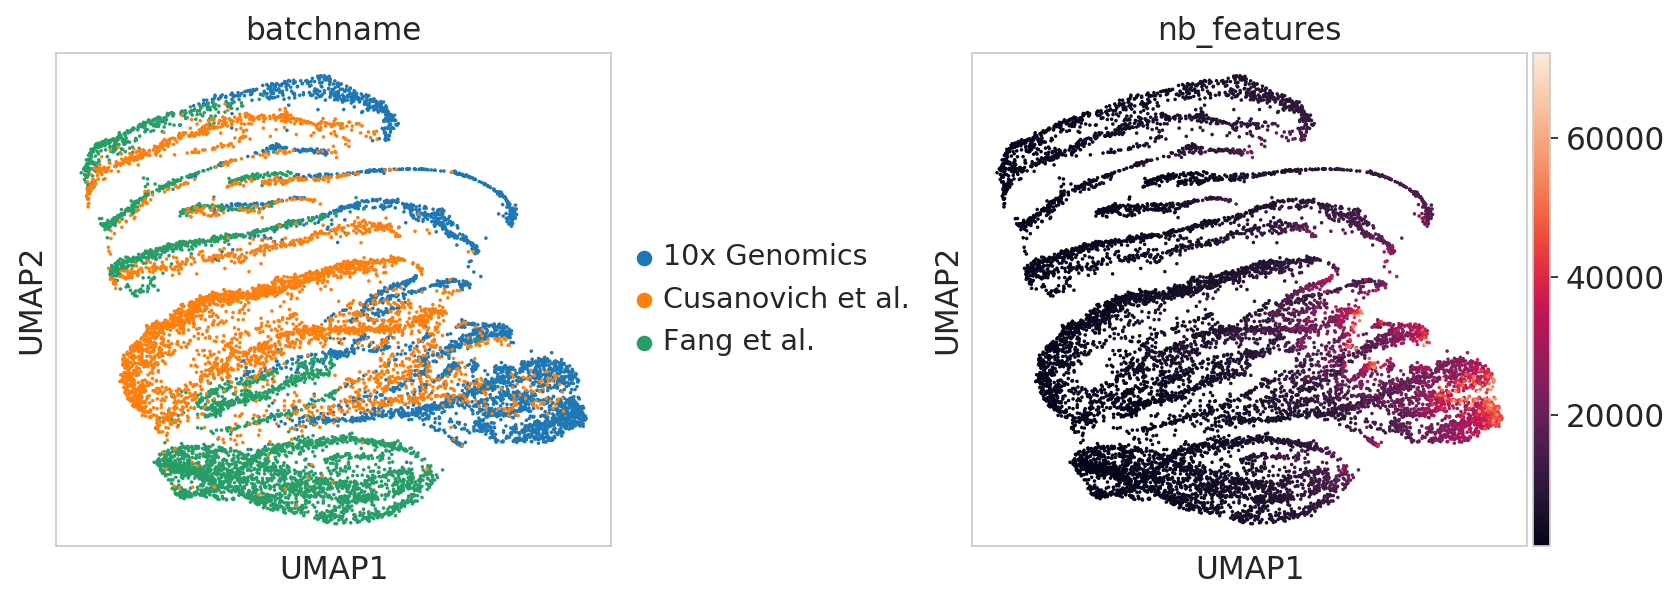

In [82]:
epi.pp.lazy(adatamerged)
sc.pl.umap(adatamerged, color=['batchname', 'nb_features'], wspace=0.5)

In [61]:
epi.pp.filter_cells(adatamerged, min_features=500)

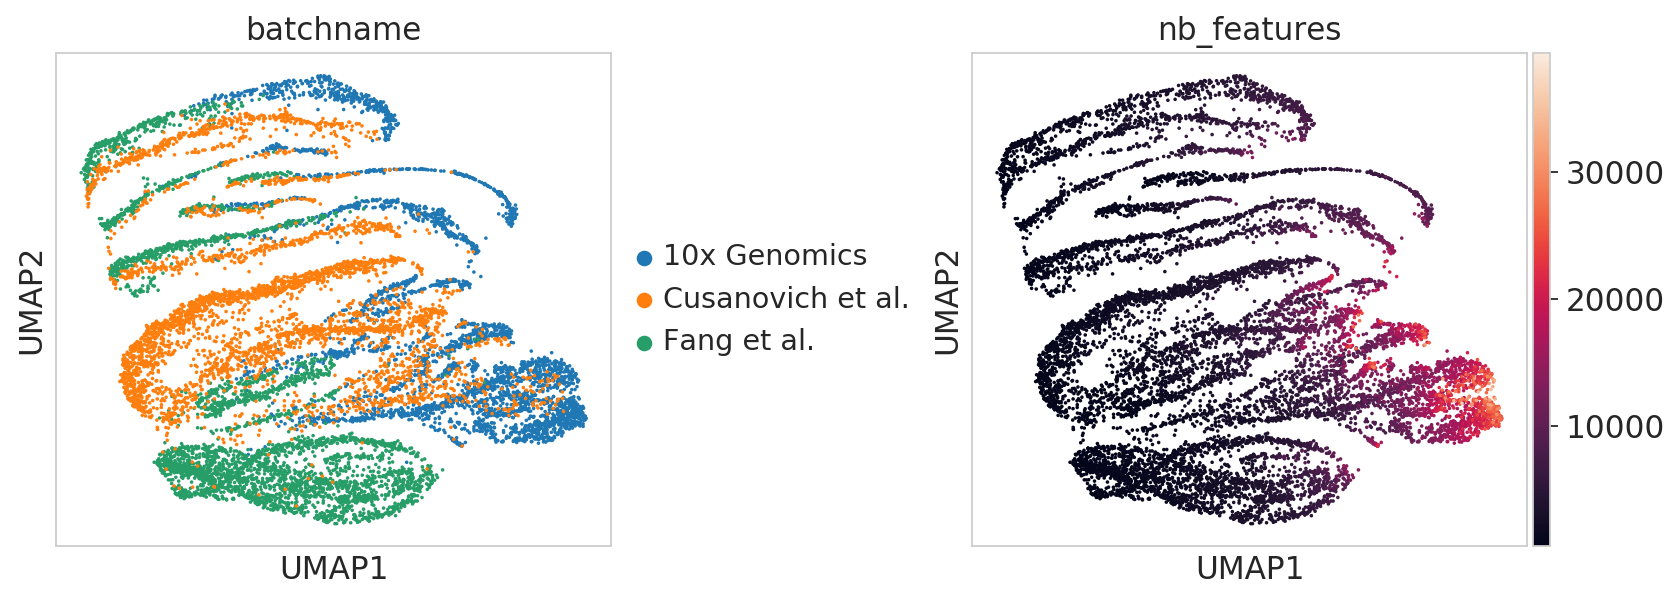

In [83]:
sc.pl.umap(adatamerged, color=['batchname', 'nb_features'], wspace=0.5)

In [62]:
epi.pp.normalize_per_cell(adatamerged)

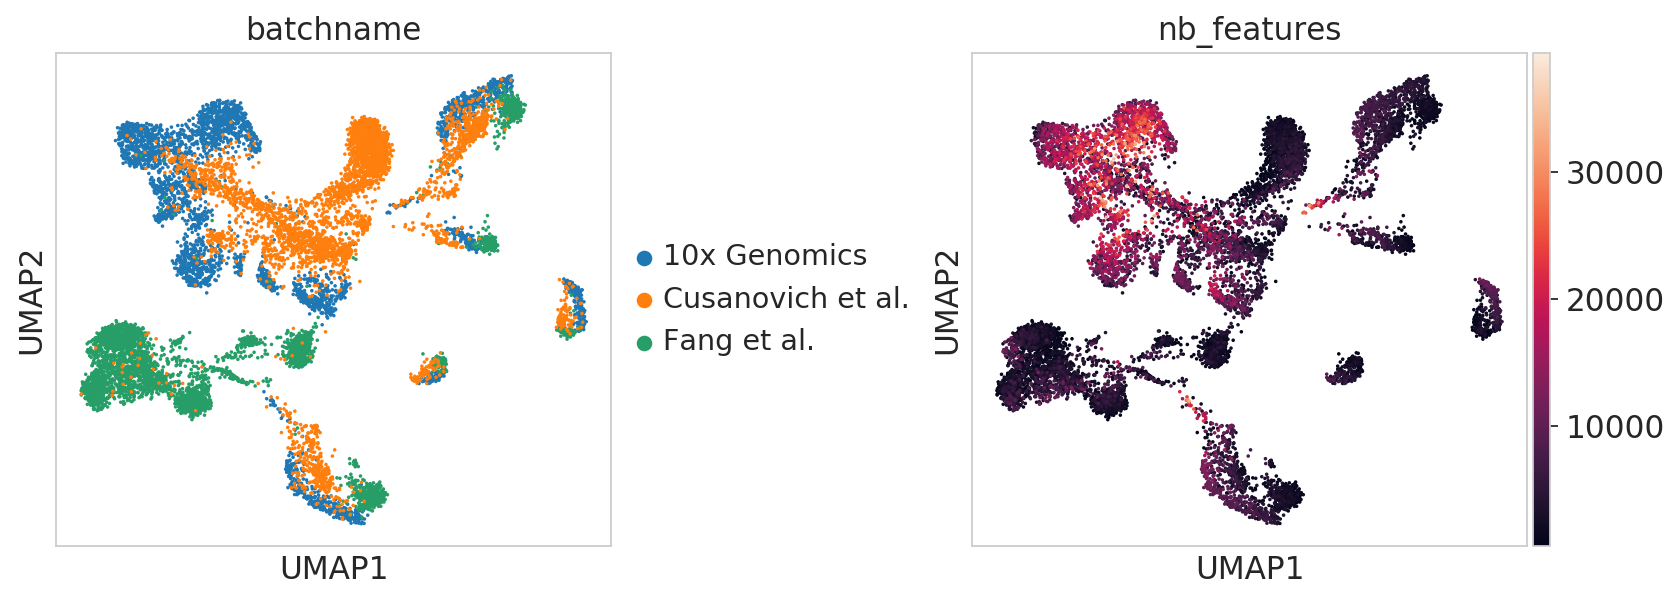

In [84]:
epi.pp.lazy(adatamerged)
sc.pl.umap(adatamerged, color=['batchname', 'nb_features'], wspace=0.5)

In [63]:
adatamerged.write('./small_peaks_dataset_merged_dataset.h5ad')

... storing 'batchname' as categorical
... storing 'filter' as categorical
... storing 'filter_barcode_cellranger' as categorical
